# Import of data for location based covid prediction and zoning the address

## Enter address of interest here to find covid prediction.

In [ ]:
addressSearch = "9309 Kittansett Dr NC 28262"

## Now run all the cells and view results at the end which shows covid predictions for the next 10 days based on the address given.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import requests
import json
import seaborn as sns
import warnings
from datetime import date 
from datetime import timedelta
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

Picking up the dynamic daily dump of COVID data based on geo location from www.trackcorona.live api and reading it into a data frame

In [4]:
data_json=requests.get(url = 'https://www.trackcorona.live/api/cities').json()
df_states = pd.read_json(json.dumps(data_json['data']))
print(df_states)
df_states_needed = df_states[['latitude','longitude','confirmed','dead', 'recovered']]
df_states_needed.head()

                            location country_code   latitude   longitude  \
0                         Beekdaelen           nl  50.918308    5.885460   
1                            Zamfara           ng  12.122181    6.223582   
2                        Pilõezinhos           br  -6.843131  -35.530578   
3                            Pavussu           br  -7.964325  -43.224345   
4          Sierra County, California           us  39.553284 -120.251273   
...                              ...          ...        ...         ...   
9893      Jessamine County, Kentucky           us  37.895573  -84.564147   
9894     Montgomery County, Maryland           us  39.154743  -77.240515   
9895        Augusta County, Virginia           us  38.200456  -79.245115   
9896        Roanoke County, Virginia           us  37.246712  -80.120526   
9897  Wansheng Economic Opening Zone           cn  27.517320  110.712695   

      confirmed   dead  recovered  velocity_confirmed  velocity_dead  \
0             0

,latitude,longitude,confirmed,dead,recovered
0,50.918308,5.885460,0,0.0,NaN
1,12.122181,6.223582,77,5.0,71.0
2,-6.843131,-35.530578,87,0.0,NaN
3,-7.964325,-43.224345,2,1.0,NaN
4,39.553284,-120.251273,3,0.0,NaN


# EDA of data for location based covid prediction and zoning the address

In [5]:
#EDA
df_states_needed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9898 entries, 0 to 9897
Data columns (total 5 columns):
latitude     9898 non-null float64
longitude    9898 non-null float64
confirmed    9898 non-null int64
dead         9653 non-null float64
recovered    1266 non-null float64
dtypes: float64(4), int64(1)
memory usage: 386.8 KB


In [6]:
print(df_states_needed.describe())
print(df_states_needed.isnull().sum())

          latitude    longitude      confirmed          dead     recovered
count  9898.000000  9898.000000    9898.000000   9653.000000   1266.000000
mean     13.908421   -43.668064     940.270863     42.970993   1221.724329
std      28.990518    52.432131    6027.191486    407.145242   4479.567421
min     -52.368047  -174.159607       0.000000      0.000000      0.000000
25%     -15.222115   -82.993161       8.000000      0.000000      4.000000
50%      25.367652   -49.016809      53.000000      1.000000     30.000000
75%      39.810473   -37.153095     314.750000      6.000000    340.750000
max      70.071821   171.695216  226280.000000  23556.000000  73872.000000
latitude        0
longitude       0
confirmed       0
dead          245
recovered    8632
dtype: int64


Performing a heat map to find the correlation between various columns here we find active and dead are related to recovered which makes logical sense

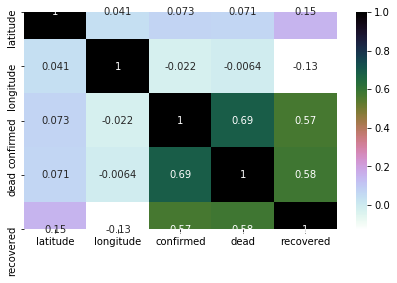

In [7]:
df_states_needed.fillna(0)
plt.figure(figsize=(7,4))
sns.heatmap(df_states_needed.corr(),annot=True,cmap='cubehelix_r')#draws heatmap with input as the correlation matrix calculated by (iris_data.corr())
plt.show()

In the heat map we were not able to find relationship between geo location and covid concentrations so we are trying a scatter plot here. It clearly indicates that covid high locations are highly clustered. Hence its worth to find a covid index at a place based on localized data for that geo location

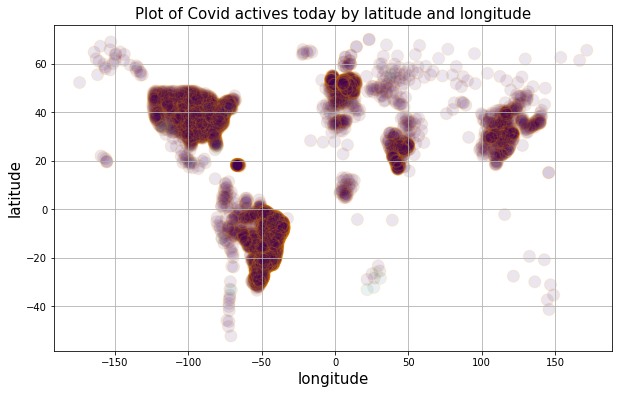

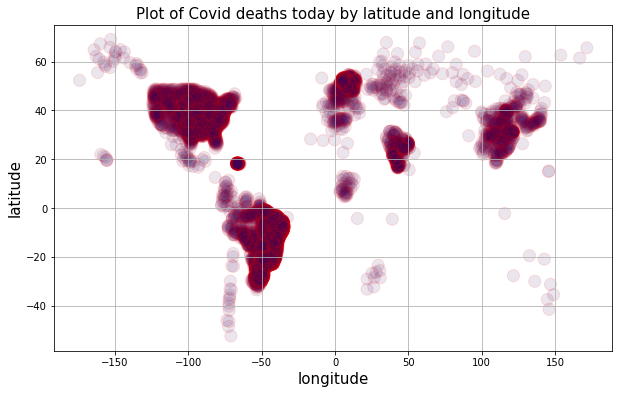

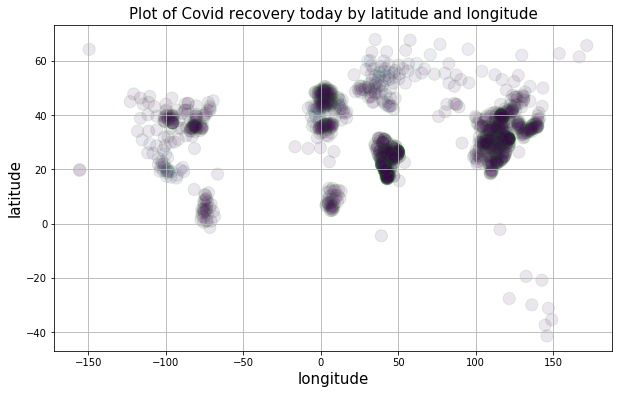

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(df_states_needed['longitude'],df_states_needed['latitude'],c=df_states_needed['confirmed'],edgecolors='orange',alpha=0.10,s=150)
plt.grid(True)
plt.xlim()
plt.title("Plot of Covid actives today by latitude and longitude",fontsize=15)
plt.xlabel("longitude",fontsize=15)
plt.ylabel("latitude",fontsize=15)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(df_states_needed['longitude'],df_states_needed['latitude'],c=df_states_needed['dead'],edgecolors='red',alpha=0.10,s=150)
plt.grid(True)
plt.xlim()
plt.title("Plot of Covid deaths today by latitude and longitude",fontsize=15)
plt.xlabel("longitude",fontsize=15)
plt.ylabel("latitude",fontsize=15)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(df_states_needed['longitude'],df_states_needed['latitude'],c=df_states_needed['recovered'],edgecolors='green',alpha=0.10,s=150)
plt.grid(True)
plt.xlim()
plt.title("Plot of Covid recovery today by latitude and longitude",fontsize=15)
plt.xlabel("longitude",fontsize=15)
plt.ylabel("latitude",fontsize=15)
plt.show()


# KNN for predicting location based covid prediction and zoning the address

Splitting into training and testing data

In [9]:
#ML to find covid index for a given geographic location

from sklearn.model_selection import train_test_split
X=df_states_needed[['latitude','longitude']]
y=df_states_needed[['confirmed','dead','recovered']].fillna(0)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(7918, 2)
(1980, 2)


Since we already found covid has relation to location we are trying to create a model by using K nearest neighbour algorithm to find the mean covid indexes for a given geographic location. Below is the MSE analysis for the model to figure out the perfect number of neighbours to get accurate results

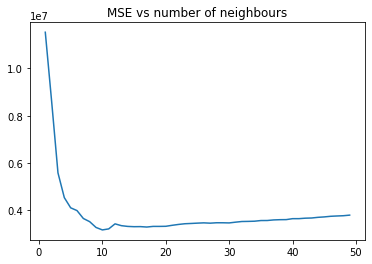

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
a=[]
c=[]
for n_value in  range(1,50):
    knnr = KNeighborsRegressor(n_neighbors = n_value)
    knnr.fit(X_train, y_train)
    a.append(n_value)
    c.append(mean_squared_error(y_test,knnr.predict(X_test)))
plt.plot(a,c)
plt.title("MSE vs number of neighbours")
plt.show()

One more try at optimizing the parameters of the KNN

In [11]:
params = {'n_neighbors': list(range(2,10))}
knnr = KNeighborsRegressor()
model = GridSearchCV(knnr, params, cv=5)
model.fit(X_train,y_train)
model.best_params_

{'n_neighbors': 9}

Finally we pick up an address to perform our predictions. Feel free to change the address to other locations in USA and check
Right here we are able to predict the covid active rate and deaths based on a given geographic location. Further we also bin the location 
into Red, Yellow and green zones. This can be specifically helpful for people to understand their level of isolation required to be safe.

In [12]:


from sklearn.neighbors import KNeighborsRegressor
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="addresscodingLatLong")
location = geolocator.geocode(addressSearch)
location_string = str(location.latitude) + ", " + str(location.longitude)
location_given = geolocator.reverse(location_string)
stateOfData = location_given.raw.get('address').get('state')
countyOfData = location_given.raw.get('address').get('county')
county_data = countyOfData.replace('County','').strip()

knnr = KNeighborsRegressor(n_neighbors = model.best_params_.get('n_neighbors'))
knnr.fit(X_train, y_train)
print("Your coordinates are ",location.latitude,location.longitude)
covid_prediction=knnr.predict([[location.latitude,location.longitude]])
print("Todays covid active index based on your location is - ", round(covid_prediction[0][0]))
print("Todays covid deaths index based on your location is - ", round(covid_prediction[0][1]))
#print("Todays covid recovery index based on your location is - ", round(covid_prediction[0][2]))

confirmed_numbers=arr = df_states_needed['confirmed'].to_numpy()[df_states_needed['confirmed'].to_numpy() != 0]
redvalue=np.percentile(confirmed_numbers, 95)
yellowvalue=np.percentile(confirmed_numbers, 75)
greenvalue=np.percentile(confirmed_numbers, 55)

def returnZone(covid_prediction):
    if covid_prediction>redvalue:
        return "Red Zone"
    elif covid_prediction>yellowvalue:
        return "Yellow Zone"
    else:
        return "Green Zone"



print("You are in ", returnZone(covid_prediction[0][0]))

Your coordinates are  35.31543927839599 -80.74129504861425
Todays covid active index based on your location is -  4097.0
Todays covid deaths index based on your location is -  49.0
You are in  Red Zone


# Import of data for time series predictions - this is to predict the future active rates at address of interest based on trend in state

Now moving on to another timeseries dataset to pick up covid data countywise

In [13]:
df_covid19_county = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

# EDA of data for time series predictions - this is to predict the future active rates at address of interest based on trend in state

In [14]:
df_covid19_county.tail()

,date,county,state,fips,cases,deaths
402063,2020-08-04,Sweetwater,Wyoming,56037.0,251,2
402064,2020-08-04,Teton,Wyoming,56039.0,362,1
402065,2020-08-04,Uinta,Wyoming,56041.0,267,1
402066,2020-08-04,Washakie,Wyoming,56043.0,53,5
402067,2020-08-04,Weston,Wyoming,56045.0,5,0


In [15]:
df_covid19_county['fips'].fillna(0,inplace=True)

Analysis on the data set to understand and see the counties in USA with highest cases

2020-08-04 00:00:00


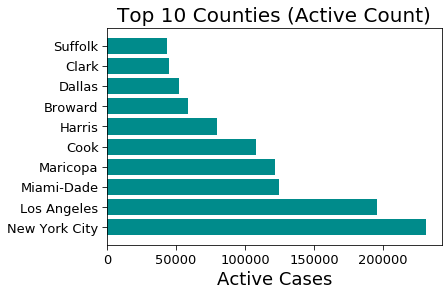

In [16]:
df_covid19_county['date'] = pd.to_datetime(df_covid19_county['date'])  
today = pd.Timestamp('today').normalize()
yesterday = today - timedelta(days = 1) 
print(yesterday)
mask = (df_covid19_county['date'] == yesterday)
df = df_covid19_county.loc[mask]

confirmed_cases= df.nlargest(10,'cases')
plt.barh(confirmed_cases['county'],confirmed_cases['cases'],color="darkcyan")
plt.xlabel("Active Cases",fontsize=18)
plt.tick_params(size=5,labelsize = 13)
plt.title("Top 10 Counties (Active Count)",fontsize=20)

plt.show()

Analysis on the data set to understand and see the counties in USA with highest deaths

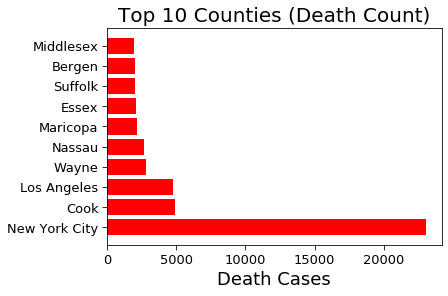

In [17]:
death_cases= df.nlargest(10,'deaths')
plt.barh(death_cases['county'],death_cases['deaths'],color="Red")
plt.xlabel("Death Cases",fontsize=18)
plt.tick_params(size=5,labelsize = 13)
plt.title("Top 10 Counties (Death Count)",fontsize=20)

plt.show()

Analysis on the data set to understand and see the counties in North carolina with highest cases

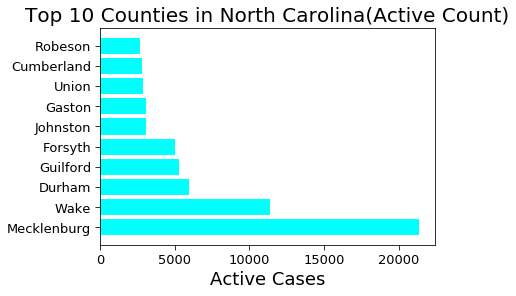

In [18]:
maskOne = (df['state'] == "North Carolina")
df = df.loc[maskOne]

confirmed_cases= df.nlargest(10,'cases')
plt.barh(confirmed_cases['county'],confirmed_cases['cases'],color="cyan")
plt.xlabel("Active Cases",fontsize=18)
plt.tick_params(size=5,labelsize = 13)
plt.title("Top 10 Counties in North Carolina(Active Count)",fontsize=20)

plt.show()

Analysis on the data set to understand and see the counties in North carolina with highest death.

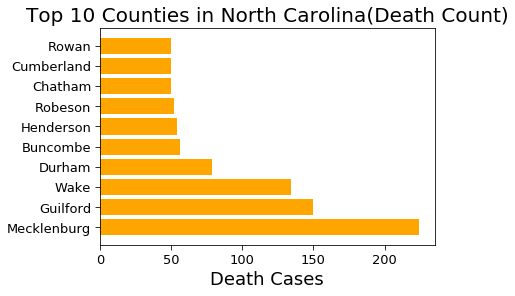

In [19]:
maskOne = (df['state'] == "North Carolina")
df = df.loc[maskOne]

confirmed_cases= df.nlargest(10,'deaths')
plt.barh(confirmed_cases['county'],confirmed_cases['deaths'],color="orange")
plt.xlabel("Death Cases",fontsize=18)
plt.tick_params(size=5,labelsize = 13)
plt.title("Top 10 Counties in North Carolina(Death Count)",fontsize=20)

plt.show()

Below we are filtering our data set in such a way that only the state and county of the address we previously specified is pulled up. This allows us to use a prediction for the location of the address instead of a generalized prediction

# Prediction using Active Cases in a state Using Linear Regression

In [20]:
df_covid_state =  pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
print(df_covid_state)

            date          state  fips  cases  deaths
0     2020-01-21     Washington    53      1       0
1     2020-01-22     Washington    53      1       0
2     2020-01-23     Washington    53      1       0
3     2020-01-24       Illinois    17      1       0
4     2020-01-24     Washington    53      1       0
...          ...            ...   ...    ...     ...
8534  2020-08-04       Virginia    51  94251    2244
8535  2020-08-04     Washington    53  61829    1706
8536  2020-08-04  West Virginia    54   7051     124
8537  2020-08-04      Wisconsin    55  60263     970
8538  2020-08-04        Wyoming    56   2884      27

[8539 rows x 5 columns]


In [21]:
maskState = (df_covid_state['state'] == "North Carolina")
df_state = df_covid_state.loc[maskState]

df_state['deaths_count'] = df_state.deaths.diff()
df_state['case_count'] = df_state.cases.diff()

df_state['case_count'].fillna(0,inplace=True)
df_state['deaths_count'].fillna(0,inplace=True)

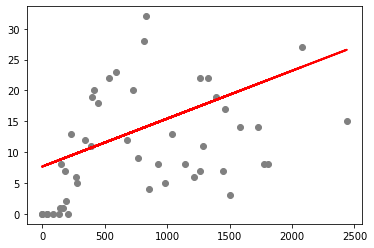

In [28]:
X = df_state['case_count'].values.reshape(-1,1)
y = df_state['deaths_count'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
regressor = LinearRegression()  

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

dftest = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df1 = dftest.head(7)

plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)

plt.show()

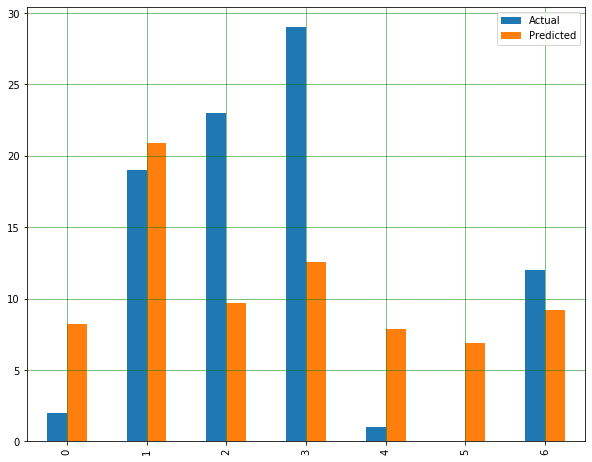

In [21]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Clearly, linear regression didn't work for this kind of data. The predictions are not accurate.

# Prediction using Active Cases in a state Using ARIMA for timeseries

The data seems to have cumulative data and hence using diff to find out the actual new cases on the time series dataset

In [22]:
state = (df_covid19_county['state'] ==stateOfData)
df_state = df_covid19_county.loc[state]

county = (df_state['county']== county_data)
df_county = df_state.loc[county]
print(df_county.head())
print(county_data)
print(stateOfData)

           date       county           state     fips  cases  deaths
1532 2020-03-12  Mecklenburg  North Carolina  37119.0      2       0
1826 2020-03-13  Mecklenburg  North Carolina  37119.0      2       0
2180 2020-03-14  Mecklenburg  North Carolina  37119.0      2       0
2592 2020-03-15  Mecklenburg  North Carolina  37119.0      4       0
3054 2020-03-16  Mecklenburg  North Carolina  37119.0      4       0
Mecklenburg
North Carolina


In [23]:
df_county['active_count'] = df_county.cases.diff()

In [24]:
print(df_county['active_count'].sum())

20862.0


In [25]:
df_active = df_county[['date','active_count']].copy()

print(df_active)

             date  active_count
1532   2020-03-12           NaN
1826   2020-03-13           0.0
2180   2020-03-14           0.0
2592   2020-03-15           2.0
3054   2020-03-16           0.0
...           ...           ...
381490 2020-07-29         217.0
384708 2020-07-30         337.0
387925 2020-07-31         241.0
391142 2020-08-01         177.0
394359 2020-08-02         185.0

[144 rows x 2 columns]


Below we are converting the date into datetime index in order to make possible for us to do statistical analysis

In [26]:
df_active['date']=pd.to_datetime(df_active['date'])

df_active.set_index('date',inplace = True)

Performing data clean up fixing all the NA's in data

In [27]:
df_active['active_count'] = df_active['active_count'].fillna(0)

Initial EDA clearly shows us that there is a trend in the covid active cases based on time

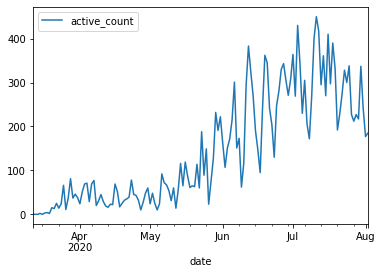

In [28]:
df_active.plot()

Here we get into performing a ARIMA moving average prediction of the timeseries for future. To start with we confirm that the average is moving with time

In [29]:
# Stationarity Testing

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

active_result=adfuller(df_active['active_count'])

In [30]:
# Type 1:  Non Stationary
# Type 2: Stationary

def adfuller_test_active(active_count):
    result_active=adfuller(active_count)
    labels_active = ['ADF_test_statistic','p-value','lags_used','No.of_observations_used']
    for value,label in zip(result_active,labels_active):
        print(label+' : '+str(value) )
    if result_active[1] <= 0.05:
        print("The null hypothesis is rejected as direct evidence of null hypothesis. Data has really no root unit, and is stationary")
    else:
            print("Poor proof for null hypothesis, time series has unit root showing that it is not stationary")

Ad Fuller test clearly indicates a moving average and hence we can apply ARIMA for predictions

In [31]:
adfuller_test_active(df_active['active_count'])

ADF_test_statistic : -1.0848830077137936
p-value : 0.7210625844868694
lags_used : 6
No.of_observations_used : 137
Poor proof for null hypothesis, time series has unit root showing that it is not stationary


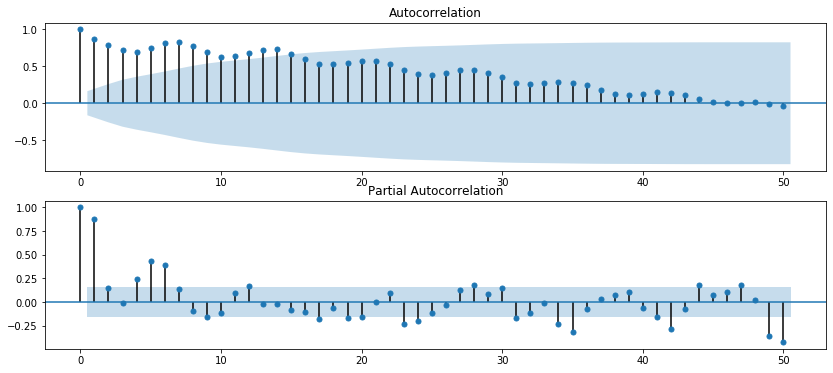

In [32]:
fig1 = plt.figure(figsize=(14,6))
ax1_1 = fig1.add_subplot(2,1,1)
fig1 = sm.graphics.tsa.plot_acf(df_active['active_count'],lags=50,ax=ax1_1)
ax2_1 = fig1.add_subplot(2,1,2)
fig1 = sm.graphics.tsa.plot_pacf(df_active['active_count'],lags=50,ax=ax2_1)

In [33]:
print(df_active['active_count'])
from statsmodels.tsa.arima_model import ARIMA
model_active=ARIMA(df_active['active_count'],order=(5,0,4))
model_fit_active=model_active.fit()

date
2020-03-12      0.0
2020-03-13      0.0
2020-03-14      0.0
2020-03-15      2.0
2020-03-16      0.0
              ...  
2020-07-29    217.0
2020-07-30    337.0
2020-07-31    241.0
2020-08-01    177.0
2020-08-02    185.0
Name: active_count, Length: 144, dtype: float64


Here we have applied our ARIMA and superimposed the results on existing data to check

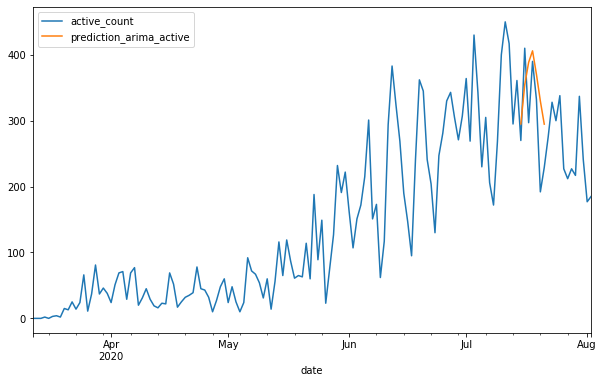

In [34]:
df_active['prediction_arima_active']=model_fit_active.predict(start=125,end=131,dynamic=True)
df_active[['active_count','prediction_arima_active']].plot(figsize=(10,6))

Now we are trying to use this for our prediction for next 10 days based on the current date. Below we are adding our future date values into the existing data and going to fill it up with projections from ARIMA model

In [35]:
from pandas.tseries.offsets import DateOffset
add_dates_active = [df_active.index[-1]+DateOffset(days=x) for x in range(0,10)]

future_dates_active = pd.DataFrame(index=add_dates_active[1:],columns=df_active.columns)

In [36]:
future_dates_active.head() 

,active_count,prediction_arima_active
2020-08-03,NaN,NaN
2020-08-04,NaN,NaN
2020-08-05,NaN,NaN
2020-08-06,NaN,NaN
2020-08-07,NaN,NaN


In [37]:
future_df_active_ar=pd.concat([df_active,future_dates_active])

Graph and table of future predictions for next 10 days based on a state and county of the address which the user has types in previously

In [38]:
count = len(df_active['active_count'])

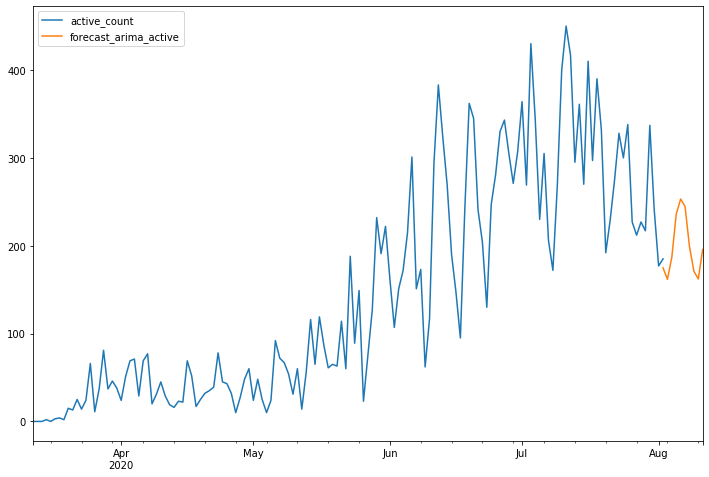

In [39]:
future_df_active_ar['forecast_arima_active'] = model_fit_active.predict(start = count-1, end = count+10, dynamic= True)  
future_df_active_ar[['active_count', 'forecast_arima_active']].plot(figsize=(12, 8))

In [40]:
#since we have used 10 in arima model to predict 10 days into future first row will always be current date
future_df_active_ar['forecast_arima_active'].tail(10)

2020-08-02    174.842934
2020-08-03    161.791784
2020-08-04    186.947930
2020-08-05    235.936813
2020-08-06    253.177685
2020-08-07    244.664597
2020-08-08    199.207773
2020-08-09    171.083783
2020-08-10    162.126687
2020-08-11    195.751642
Name: forecast_arima_active, dtype: float64

# Combining the output of the two models - a) deriving the active cases of COVID based on a address done using KNN b) extrapolating those numbers and predicting future values of COVID based on ARIMA modelling of trend in the state

Here we are picking up the covid actives being predicted previously based on KNN and then injecting it as the current COVID rate in the arima model and adjusting the remaining projected values for future by proportionality and finding the numbers of the future covid cases based on a given geographical address

Thus we have a tool now to understand the location of an address dynamically, Find the covid active and deaths dynamically and also zone the area. Further the tool is also predicting the actives for the next 10 days all a click of a button and based on realtime data feed coming in from  www.trackcorona.live and https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv

## Here are your results

In [41]:
print("Given address is: ", addressSearch)
location_string = str(location.latitude) + ", " + str(location.longitude)
location_given = geolocator.reverse(location_string)
print("Your state is : ", location_given.raw.get('address').get('state'))
print("Todays covid active index based on your location is - ", round(covid_prediction[0][0]))
print("Todays covid deaths index based on your location is - ", round(covid_prediction[0][1]))
print("You are in ", returnZone(covid_prediction[0][0]))
compareFraction = round(covid_prediction[0][0])/future_df_active_ar['forecast_arima_active'].tail(10)[0]
covid_area_predictions = future_df_active_ar['forecast_arima_active'].tail(10)*compareFraction
print("The future 10 day active COVID predictions for ur location based on your state trend is: ")
print(round(covid_area_predictions))


Given address is:  9309 Kittansett Dr NC 28262
Your state is :  North Carolina
Todays covid active index based on your location is -  4062.0
Todays covid deaths index based on your location is -  50.0
You are in  Red Zone
The future 10 day active COVID predictions for ur location based on your state trend is: 
2020-08-02    4062.0
2020-08-03    3759.0
2020-08-04    4343.0
2020-08-05    5481.0
2020-08-06    5882.0
2020-08-07    5684.0
2020-08-08    4628.0
2020-08-09    3975.0
2020-08-10    3767.0
2020-08-11    4548.0
Name: forecast_arima_active, dtype: float64
